# Deep Learning for Pneumonia Detection: Classifying Chest X-rays with CNNs in PyTorch

## By: Mustafa Yildirim

https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

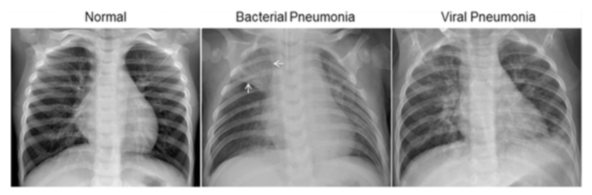

Figure S6. Illustrative Examples of Chest X-Rays in Patients with Pneumonia, Related to Figure 6
The normal chest X-ray (left panel) depicts clear lungs without any areas of abnormal opacification in the image. Bacterial pneumonia (middle) typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows), whereas viral pneumonia (right) manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs.
http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

Content
The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

Acknowledgements
Data: https://data.mendeley.com/datasets/rscbjbr9sj/2

License: CC BY 4.0

Citation: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

Importing Libraries

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary
from sklearn.metrics import classification_report, confusion_matrix
import kagglehub

Downloading the Chest Xray Pneumonia Dataset

In [2]:
# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

train_path = os.path.join(path, "chest_xray", "train")
val_path = os.path.join(path, "chest_xray", "val")
test_path = os.path.join(path, "chest_xray", "test")

In [ ]:
normal_images = [f for f in os.listdir(os.path.join(train_path, "NORMAL")) if f.endswith(('.png', '.jpg', '.jpeg'))]
pneumonia_images = [f for f in os.listdir(os.path.join(train_path, "PNEUMONIA")) if f.endswith(('.png', '.jpg', '.jpeg'))]

print("Number if normal images:", len(normal_images))
print("Normal X-ray Samples:", normal_images[:5])  
print(" ")

print("Number if pneumonia images:", len(pneumonia_images))
print("Pneumonia X-ray Samples:", pneumonia_images[:5])  

Number if normal images: 1341
Normal X-ray Samples: ['IM-0115-0001.jpeg', 'IM-0117-0001.jpeg', 'IM-0119-0001.jpeg', 'IM-0122-0001.jpeg', 'IM-0125-0001.jpeg']
 
Number if pneumonia images: 3875
Pneumonia X-ray Samples: ['person1000_bacteria_2931.jpeg', 'person1000_virus_1681.jpeg', 'person1001_bacteria_2932.jpeg', 'person1002_bacteria_2933.jpeg', 'person1003_bacteria_2934.jpeg']


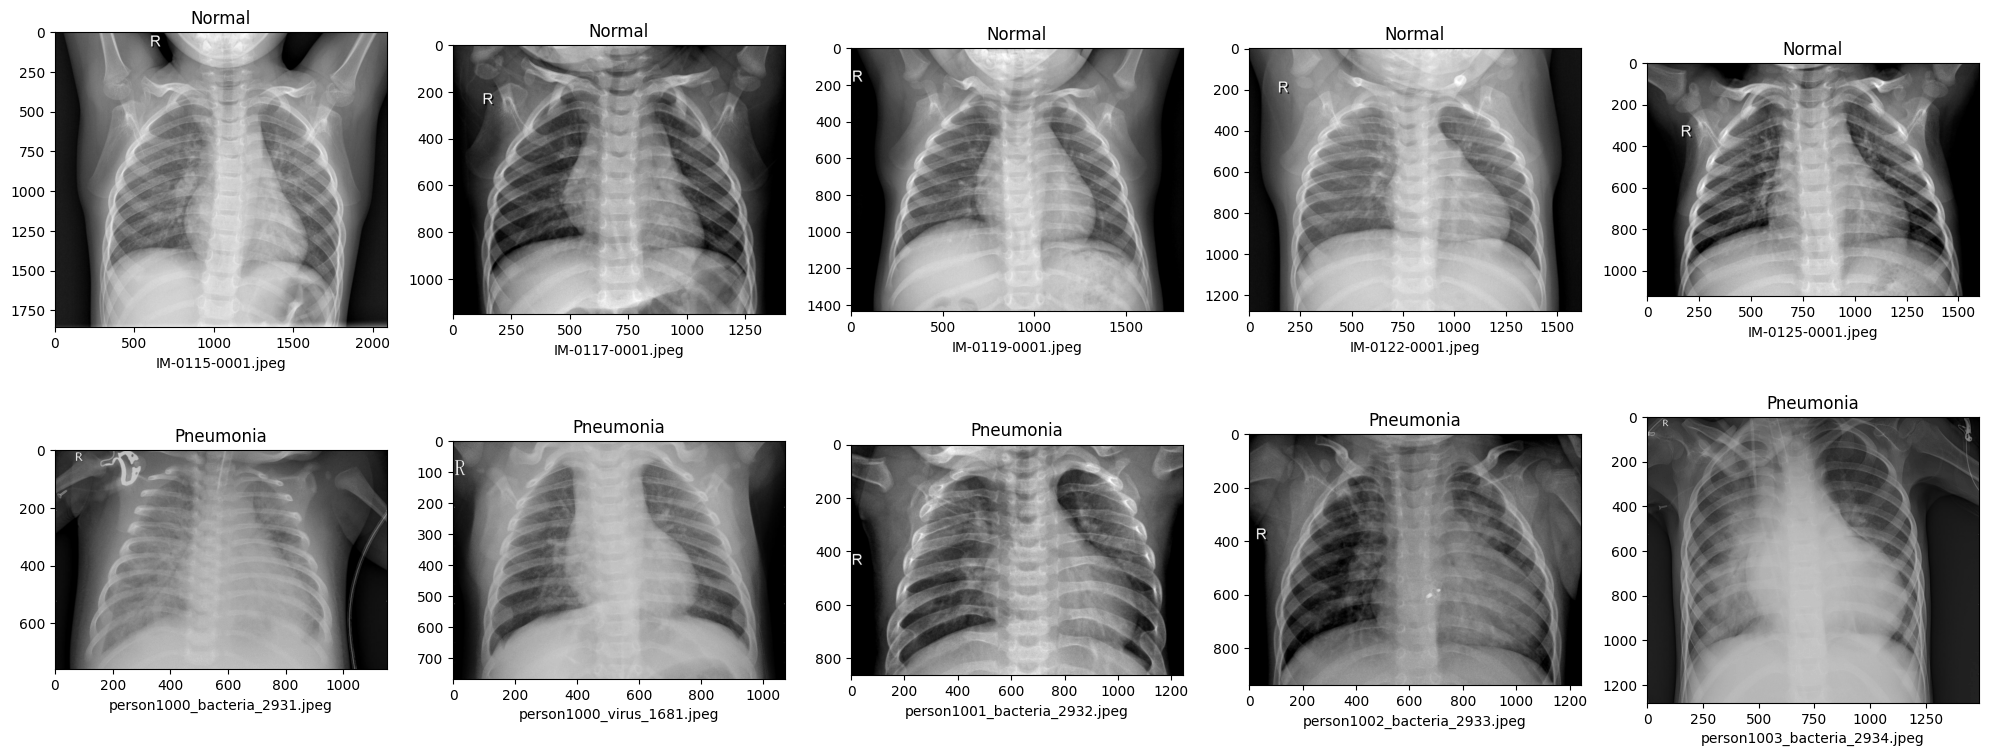

In [ ]:
num_images = 5
# First 5 normal images
selected_normal = normal_images[:num_images]
# First 5 pneumonia images  
selected_pneumonia = pneumonia_images[:num_images]  

fig, axes = plt.subplots(2, num_images, figsize=(20, 8))

for i, image_file in enumerate(selected_normal):
    img_path = os.path.join(train_path, "NORMAL", image_file)
    img = Image.open(img_path)

    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].set_title("Normal", fontsize=12)
    axes[0, i].set_xlabel(image_file, fontsize=10)

for i, image_file in enumerate(selected_pneumonia):
    img_path = os.path.join(train_path, "PNEUMONIA", image_file)
    img = Image.open(img_path)

    axes[1, i].imshow(img, cmap='gray')
    axes[1, i].set_title("Pneumonia", fontsize=12)
    axes[1, i].set_xlabel(image_file, fontsize=10)

plt.tight_layout()
plt.show()

Functions for processing and loading the data

In [5]:
def preprocess_img(image_path, size=(128, 128)):
    img = cv2.imread(image_path)    
    resized_img = cv2.resize(img, size)
    gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
    eq_img = cv2.equalizeHist(gray_img)
    blurred_img = cv2.GaussianBlur(eq_img, (3, 3), 0)
    norm_img = blurred_img.astype('float32') / 255.0
    img_tensor = torch.tensor(norm_img, dtype=torch.float32).unsqueeze(0)
    
    return img_tensor


def load_data(split_paths):
    data = []
    labels = []

    for category, path in split_paths.items():
        # Assign label
        label = 0 if category.lower() == "normal" else 1  

        if not os.path.isdir(path):
            print(f"Error: {path} is not a valid directory")
            continue

        for filename in os.listdir(path):
            file_path = os.path.join(path, filename)
            
            if os.path.isfile(file_path):
                img = preprocess_img(file_path)
                
                if img is not None:
                    data.append(img)
                    labels.append(label)

    data_tensor = torch.stack(data)
    labels_tensor = torch.tensor(labels, dtype=torch.float32).view(-1, 1)
    
    return data_tensor, labels_tensor

In [6]:
split_paths_train = {
    "normal": os.path.join(train_path, "NORMAL"),
    "pneumonia": os.path.join(train_path, "PNEUMONIA")
}

split_paths_val = {
    "normal": os.path.join(val_path, "NORMAL"),
    "pneumonia": os.path.join(val_path, "PNEUMONIA")
}

split_paths_test = {
    "normal": os.path.join(test_path, "NORMAL"),
    "pneumonia": os.path.join(test_path, "PNEUMONIA")
}

X_train_tensor, y_train_tensor = load_data(split_paths_train)
X_val_tensor, y_val_tensor = load_data(split_paths_val)
X_test_tensor, y_test_tensor = load_data(split_paths_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
X_train_tensor.shape, y_train_tensor.shape

(torch.Size([5216, 1, 128, 128]), torch.Size([5216, 1]))

The CNN architecture

In [8]:
class CnnModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            # Convolutional Layers
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Flatten(),
            
            # Fully Connected Layers
            nn.Linear(128 * 16 * 16, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            # Binary classification
            nn.Linear(128, 1),  
            nn.Sigmoid()
        )

    def forward(self,x):
        return self.layers(x)


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CnnModel().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

criterion = nn.BCELoss()

summary(model, input_size=(1, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
CnnModel                                 [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Conv2d: 2-1                       [1, 32, 128, 128]         320
│    └─ReLU: 2-2                         [1, 32, 128, 128]         --
│    └─MaxPool2d: 2-3                    [1, 32, 64, 64]           --
│    └─Conv2d: 2-4                       [1, 32, 64, 64]           9,248
│    └─ReLU: 2-5                         [1, 32, 64, 64]           --
│    └─Conv2d: 2-6                       [1, 64, 64, 64]           18,496
│    └─ReLU: 2-7                         [1, 64, 64, 64]           --
│    └─MaxPool2d: 2-8                    [1, 64, 32, 32]           --
│    └─Conv2d: 2-9                       [1, 128, 32, 32]          73,856
│    └─ReLU: 2-10                        [1, 128, 32, 32]          --
│    └─MaxPool2d: 2-11                   [1, 128, 16, 16]          --
│  

Training the model

In [ ]:
num_epochs = 50
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_loss = float('inf')
patience = 5
counter = 0

for epoch in range(num_epochs):
    
    model.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds = (outputs >= 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)


    # Validation Phase
    model.eval()
    val_loss = 0.0
    correct_val, total_val = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float()

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = (outputs >= 0.5).float()
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}!")
            break

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

print("Training Complete")

Epoch 1/50, Train Loss: 0.5284, Train Acc: 0.7569, Val Loss: 0.6425, Val Acc: 0.7500
Epoch 2/50, Train Loss: 0.3442, Train Acc: 0.8177, Val Loss: 0.6798, Val Acc: 0.6250
Epoch 3/50, Train Loss: 0.2865, Train Acc: 0.8669, Val Loss: 0.5068, Val Acc: 0.7500
Epoch 4/50, Train Loss: 0.2355, Train Acc: 0.9066, Val Loss: 0.6997, Val Acc: 0.6875
Epoch 5/50, Train Loss: 0.1867, Train Acc: 0.9300, Val Loss: 0.6579, Val Acc: 0.7500
Epoch 6/50, Train Loss: 0.1531, Train Acc: 0.9434, Val Loss: 0.4851, Val Acc: 0.8125
Epoch 7/50, Train Loss: 0.1526, Train Acc: 0.9369, Val Loss: 0.8270, Val Acc: 0.6875
Epoch 8/50, Train Loss: 0.1315, Train Acc: 0.9507, Val Loss: 0.3861, Val Acc: 0.8125
Epoch 9/50, Train Loss: 0.1211, Train Acc: 0.9567, Val Loss: 0.3390, Val Acc: 0.7500
Epoch 10/50, Train Loss: 0.1097, Train Acc: 0.9586, Val Loss: 1.0023, Val Acc: 0.6250
Epoch 11/50, Train Loss: 0.0985, Train Acc: 0.9636, Val Loss: 0.3295, Val Acc: 0.8750
Epoch 12/50, Train Loss: 0.0891, Train Acc: 0.9653, Val Loss: 0

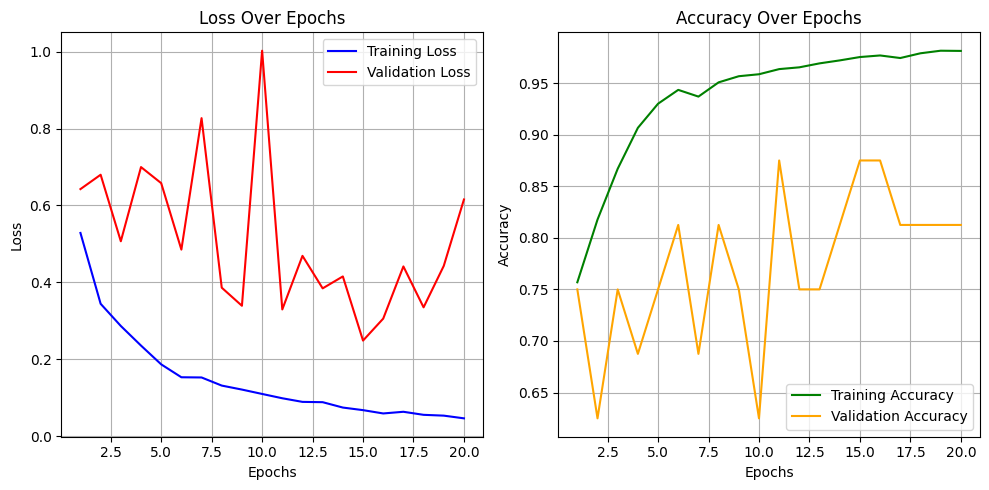

In [11]:
plt.figure(figsize=(10, 5))

completed_epochs = len(train_losses)

plt.subplot(1, 2, 1)
plt.plot(range(1, completed_epochs + 1), train_losses, linestyle='-', color='b', label='Training Loss')
plt.plot(range(1, completed_epochs + 1), val_losses, linestyle='-', color='r', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(range(1, completed_epochs + 1), train_accuracies, linestyle='-', color='g', label='Training Accuracy')
plt.plot(range(1, completed_epochs + 1), val_accuracies, linestyle='-', color='orange', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Testing the model

In [ ]:
model.eval()
test_loss = 0.0
correct_test, total_test = 0, 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float()

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        preds = (outputs >= 0.5).float()
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        correct_test += (preds == labels).sum().item()
        total_test += labels.size(0)

test_loss /= len(test_loader)
test_accuracy = correct_test / total_test

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 3.5483, Test Accuracy: 0.7163


Result visualization

In [13]:
print("Classification Report:")

all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()

print(classification_report(all_labels, all_preds, target_names=["Normal","Pneumonia"]))

Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.25      0.40       234
   Pneumonia       0.69      0.99      0.81       390

    accuracy                           0.72       624
   macro avg       0.83      0.62      0.61       624
weighted avg       0.79      0.72      0.66       624



Findings: The model achieves high recall for pneumonia (0.99) but struggles with normal cases, showing low recall (0.25) and misclassifying many normal images as pneumonia.

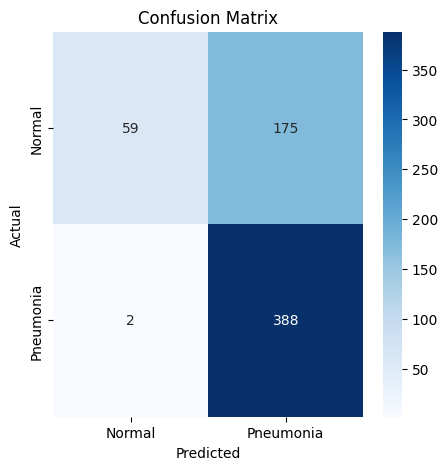

In [14]:
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Findings: The confusion matrix confirms this bias, with 175 false positives for pneumonia and only 59 true positives for normal cases, indicating class imbalance issues or a tendency to favor pneumonia predictions.